## Installations & Imports

### Installations

In [4]:
!wget https://dl.google.com/cloud_tpu/ctpu/latest/linux/ctpu && chmod a+x ctpu

--2020-11-13 15:30:44--  https://dl.google.com/cloud_tpu/ctpu/latest/linux/ctpu
Resolving dl.google.com (dl.google.com)... 108.177.126.136, 108.177.126.93, 108.177.126.190, ...
Connecting to dl.google.com (dl.google.com)|108.177.126.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25791658 (25M) [application/octet-stream]
Saving to: ‘ctpu’

ctpu                100%[===================>]  24.60M   107MB/s    in 0.2s    

2020-11-13 15:30:44 (107 MB/s) - ‘ctpu’ saved [25791658/25791658]



In [30]:
!pip install tf-nightly==2.5.0.dev20201113

     |███████████████████████▍        | 289.3 MB 113.5 MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 395.9 MB 2.2 kB/s 
     |████████████████████████████████| 127 kB 74.0 MB/s eta 0:00:01
     |████████████████████████████████| 10.6 MB 72.0 MB/s eta 0:00:01
     |████████████████████████████████| 461 kB 79.4 MB/s eta 0:00:01
     |████████████████████████████████| 14.5 MB 57.9 MB/s eta 0:00:01
  Attempting uninstall: absl-py
    Found existing installation: absl-py 0.8.1
    Uninstalling absl-py-0.8.1:
      Successfully uninstalled absl-py-0.8.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Attempting uninstall: tb-nightly
    Found existing installation: tb-nightly 2.5.0a20201113
    Uninstalling tb-nightly-2.5.0a20201113:
      Successfully uninstalled tb-nightly-2.5.0a20201113
  Attempting uninstall: tf-estimator-nightly
    Found existing installation: tf-estimator-nightly 2.5.0.dev2020111301
    Uninstalling tf-estimator-nightly-2.5.

In [1]:
!pip install tensorflow

     |████████████████████████████████| 20.1 MB 14.8 MB/s eta 0:00:01
     |████████████████████████████████| 26.1 MB 73.6 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.4
    Uninstalling numpy-1.19.4:
      Successfully uninstalled numpy-1.19.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.2
    Uninstalling scipy-1.5.2:
      Successfully uninstalled scipy-1.5.2
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tfx-bsl 0.23.0 requires absl-py<0.9,>=0.7, but you'll have absl-py 0.11.0 which is incompatible.
tfx-bsl 0.23.0 requires pyarrow<0.18,>=0.17, but you'll have pyarrow 1.0.1 which is incompatible.
tf-nightly 2.5.0.dev20201113 requires numpy~=1.19.2, but you'll have nu

In [2]:
!pip install tensorboard

### Imports

In [1]:
import keras
import os
import tensorflow as tf

Using TensorFlow backend.


In [2]:
print(tf.__version__)

2.3.1


In [3]:
import numpy as np
import random
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import SVG

import tensorboard
from tqdm.notebook import tqdm
from tensorflow import keras
from sklearn.utils import class_weight
from sklearn.preprocessing import normalize
from tensorflow.data import Dataset

from sklearn.metrics import confusion_matrix

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Initialization

In [4]:
%reload_ext tensorboard

In [5]:
#%env GCE_PROJECT_NAME my-sample-tpu-project
%env TPU_ZONE europe-west4-a
%env TPU_NAME deep-learning-online-vm
%env TPU_IP_RANGE 10.240.1.2
%env DATA_PATH gs://cs-229-project-data/data
%env CKPT_PATH gs://cs-229-project-model/training
%env MODEL_PATH gs://cs-229-project-model/models
%env LOG_PATH gs://cs-229-project-model/logs/scalars
    
# Automatically get bucket name from GCS paths
import os
os.environ['DATA_BUCKET'] = os.environ['DATA_PATH'][5:].split('/')[0]
os.environ['CKPT_BUCKET'] = os.environ['CKPT_PATH'][5:].split('/')[0]

env: TPU_ZONE=europe-west4-a
env: TPU_NAME=deep-learning-online-vm
env: TPU_IP_RANGE=10.240.1.2
env: DATA_PATH=gs://cs-229-project-data/data
env: CKPT_PATH=gs://cs-229-project-model/training
env: MODEL_PATH=gs://cs-229-project-model/models
env: LOG_PATH=gs://cs-229-project-model/logs/scalars


In [6]:
!ls

20201114-112009-small_resnet50_2400_samples.tf	raw_hurricane-harvey.npz
ctpu						raw_hurricane-matthew.npz
data						raw_hurricane-michael.npz
diagnose_tensorboard.py				train_history_20_epochs.npz
full_data.npz					training.py
full_data_VGG_processed.npz			training.py~
Model Training.ipynb				Y_data.npz
raw_hurricane-florence.npz


### Hardware

In [39]:
# Detect hardware
try:
    tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu_resolver = None
    gpus = tf.config.experimental.list_logical_devices("GPU")

    # Select appropriate distribution strategy
if tpu_resolver:
    tf.config.experimental_connect_to_cluster(tpu_resolver)
    tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
    strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
    print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on CPU')

    print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: deep-learning-online-vm


INFO:tensorflow:Initializing the TPU system: deep-learning-online-vm


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  ['10.240.1.2:8470']


In [143]:
# Detect hardware
try:
    tpu_resolver = tf.contrib.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu_resolver = None
    gpus = tf.config.experimental.list_logical_devices("GPU")

    # Select appropriate distribution strategy
if tpu_resolver:
    tf.config.experimental_connect_to_cluster(tpu_resolver)
    tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
    strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
    print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on CPU')

    print("Number of accelerators: ", strategy.num_replicas_in_sync)

AttributeError: module 'tensorflow' has no attribute 'contrib'

In [6]:
!ctpu status

Your cluster is in an unhealthy state.
	Compute Engine VM:  RUNNING
	Cloud TPU:          STOPPED


In [ ]:
!ctpu delete

## Loading Data

### Loading From Google Cloud Storage Buckets

In [353]:
!gsutil cp gs://cs-229-project-data/data/holdout_hurricane-florence.npz .

Copying gs://cs-229-project-data/data/holdout_hurricane-florence.npz...
\ [1 files][116.4 MiB/116.4 MiB]                                                
Operation completed over 1 objects/116.4 MiB.                                    


In [354]:
!gsutil cp gs://cs-229-project-data/data/holdout_hurricane-harvey.npz .

Copying gs://cs-229-project-data/data/holdout_hurricane-harvey.npz...
\ [1 files][403.0 MiB/403.0 MiB]                                                
Operation completed over 1 objects/403.0 MiB.                                    


In [355]:
!gsutil cp gs://cs-229-project-data/data/holdout_hurricane-matthew.npz .

Copying gs://cs-229-project-data/data/holdout_hurricane-matthew.npz...
/ [1 files][202.3 MiB/202.3 MiB]                                                
Operation completed over 1 objects/202.3 MiB.                                    


In [356]:
!gsutil cp gs://cs-229-project-data/data/holdout_hurricane-michael.npz .

Copying gs://cs-229-project-data/data/holdout_hurricane-michael.npz...
\ [1 files][339.4 MiB/339.4 MiB]                                                
Operation completed over 1 objects/339.4 MiB.                                    


In [360]:
!ls -a

.
..
20201114-112009-small_resnet50_2400_samples.tf
ctpu
data
diagnose_tensorboard.py
full_data.npz
full_data_VGG_processed.npz
holdout_hurricane-florence.npz
holdout_hurricane-harvey.npz
holdout_hurricane-matthew.npz
holdout_hurricane-michael.npz
.ipynb_checkpoints
Model Training Evaluation.ipynb
Model Training.ipynb
raw_hurricane-florence.npz
raw_hurricane-harvey.npz
raw_hurricane-matthew.npz
raw_hurricane-michael.npz
train_aug_history_30_epochs.npz
train_aug_indices.npz
train_aug_retrain_history_30_epochs.npz
train_aug_retrain_indices.npz
train_aug_shear_history_30_epochs.npz
train_aug_shear_indices.npz
train_history_20_epochs.npz
training.py
training.py~
Y_data.npz


### Load from Compressed Files

In [6]:
from keras.applications.resnet_v2 import preprocess_input as resnet_preprocess

In [361]:
hurricanes = ['florence', 'harvey', 'matthew', 'michael']

In [362]:
input_flo = np.load('holdout_hurricane-{}.npz'.format(hurricanes[0]))
input_har = np.load('holdout_hurricane-{}.npz'.format(hurricanes[1]))
input_mat = np.load('holdout_hurricane-{}.npz'.format(hurricanes[2]))
input_mic = np.load('holdout_hurricane-{}.npz'.format(hurricanes[3]))

In [363]:
X_flo, Y_flo = input_flo['input_images'], input_flo['input_labels']

In [364]:
X_har, Y_har = input_har['input_images'], input_har['input_labels']

In [365]:
X_mat, Y_mat = input_mat['input_images'], input_mat['input_labels']

In [366]:
X_mic, Y_mic = input_mic['input_images'], input_mic['input_labels']

### Save Data For Data Generator

In [24]:
def save_arrays_to_file(arr, start_index=0, path='gs://cs-229-project-data/data'):
    for i in tqdm(list(range(arr.shape[0])), desc='Numpy images Processed: ', unit='images', total=arr.shape[0]):
        np.save('{}/{}.npy'.format(path, i + start_index), arr[i])
    return arr.shape[0] + start_index

In [367]:
X_holdout = np.vstack((X_flo, X_har, X_mat, X_mic))

In [368]:
Y_holdout = np.vstack((Y_flo, Y_har, Y_mat, Y_mic))

In [370]:
Y_holdout.shape

(19829, 4)

In [20]:
np.savez_compressed('Y_data.npz', Y=Y)

In [9]:
Y = np.load('Y_data.npz')['Y']

## Load & Preprocess

In [25]:
np.savez_compressed('full_data.npz', X=X, Y=Y)

In [8]:
full_data = np.load('full_data.npz')

In [9]:
X, Y = full_data['X'], full_data['Y']

In [10]:
X, Y = resnet_preprocess(full_data['X']), full_data['Y']

In [11]:
def subtract_mean_rgb(images):
    """
    :param images: a numpy array of images
    :returns: images from which the mean pixel values (rgb) have been subtracted
    """
    n, w, h, c = images.shape
    reshaped_images = images.reshape((n, w*h, c))
    means = np.mean(reshaped_images, axis=1)
    reshaped_images = reshaped_images - means.reshape((n, -1, 3))
    return reshaped_images.reshape((n, w, h, c))

In [12]:
X = subtract_mean_rgb(X)

In [13]:
np.savez_compressed('full_data_VGG_processed.npz', X=X, Y=Y)

KeyboardInterrupt: 

In [16]:
X.nbytes / 1e9

39.79057152

## Shuffle Train & Validation

In [10]:
indices = list(range(Y.shape[0]))
np.random.shuffle(indices)

In [11]:
train_index = 57600
train_index

57600

In [12]:
train_index / 3200

18.0

In [13]:
# Batch Size
train_batch_size = 320
train_batch_size

320

In [14]:
train_indices, test_indices = indices[:train_index], indices[train_index:]
y_train, y_test = Y[train_indices], Y[test_indices]

In [15]:
test_indices = test_indices[:8400]
y_test = Y[test_indices]

In [16]:
y_train.shape

(57600, 4)

In [17]:
y_test.shape

(8400, 4)

In [18]:
8400 / 400

21.0

In [19]:
classes = np.array([list(x).index(1) for x in y_train])
classes

array([2, 3, 2, ..., 2, 0, 0])

In [20]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(classes), classes)
class_weights = dict(enumerate(class_weights))
class_weights

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3], y=[2 3 2 ... 2 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.4736374699865145,
 1: 1.1355571327182399,
 2: 1.245136186770428,
 3: 4.879701796001355}

## Data Generator for Batch Processing

Built on top of: Shervine Amidi https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [ ]:
def TPUDataGenerator(file_path, index_list, batch_size):
    
    label_path = os.path.join(file_path,’label')
    data_path = os.path.join(file_path,’train')
    original_index_list = index_list
                             
    while True:
        x_list = list()
        y_list = list()
        index_list = copy.copy(original_index_list)
                             
        while len(index_list) > 0:
            index = index_list.pop()
            label_index = index.strip(‘.npy’)+’_label.npy’
            x_data = np.load(os.path.join(data_path,index))
            y_data = np.load(os.path.join(label_path,label_index))
            x_list.append(x_data)
            y_list.append(y_data)
                             
            if len(x_list) == batch_size :
                 yield np.asarray(x_list), np.asarray(y_list)
                 x_list = list()
                 y_list = list()
                                                                          
            if (len(x_list) > 0 and len(index_list) == 0):
                 x_list = list()
                 y_list = list()

In [156]:
def WhileDataGenerator(list_IDs, data, labels, sequence_length, batch_size=160):
    """A generator yields (seq, target) arrays for training."""
    while True:
        offset = np.random.randint(0, sequence_length)
        IDs = list_IDs[offset*batch_size:(offset+1)*batch_size]

        yield (
            data[IDs],
            labels[IDs]
        )

In [ ]:
class DataGeneratorOld(keras.utils.Sequence):
    'Generates data for Keras'
    
    def __init__(self, list_IDs, labels, batch_size=800, dim=(224, 224), n_channels=3,
                 n_classes=4, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('gs://cs-229-mode-training/data/{}.npy'.format(ID))

            # Store class
            y[i] = self.labels[ID]

        return X, y

In [123]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    
    def __init__(self, list_IDs, data, labels, batch_size=800, dim=(224, 224), n_channels=3,
                 n_classes=4, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.X = data
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        x, y = self.__data_generation(list_IDs_temp)

        return x, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        x = self.X[list_IDs_temp]
        y = self.labels[list_IDs_temp]

        return x, y

In [125]:
training_generator = DataGenerator(train_indices, X, Y, batch_size=160)
validation_generator = DataGenerator(test_indices, X, Y, batch_size=1000)

In [102]:
training_generator = WhileDataGenerator(list(range(2000)), X[:2000], Y[:2000], sequence_length=20, batch_size=100)
validation_generator = WhileDataGenerator(list(range(1000)), X[5000:6000], Y[5000:6000], sequence_length=1, batch_size=1000)

NameError: name 'WhileDataGenerator' is not defined

## Streaming Dataset 

In [ ]:
train_dataset = Dataset.from_tensor_slices((X[train_indices], Y[train_indices]))

In [ ]:
x_train

### Converting to TensorFlow Dataset => Kernel crashed multiple times with different machines if not

2020-11-13 20:50:32.411397: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
E1113 20:51:10.074836020    3778 proto_buffer_writer.h:83]   assertion failed: byte_count_ < total_size_

In [ ]:
train_dataset = Dataset.from_tensor_slices((X_train, y_train))

In [ ]:
test_dataset = Dataset.from_tensor_slices((X_test, y_test))

## Preprocessing Generator

In [21]:
from keras.applications.resnet_v2 import preprocess_input as resnet_preprocess

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [23]:
train_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess, rotation_range=35, shear_range=7, 
                                   brightness_range=(0.80,1.2), channel_shift_range=20, horizontal_flip=True, 
                                   vertical_flip=True, fill_mode='nearest', data_format='channels_last')

In [348]:
train_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess, rotation_range=45, shear_range=4, 
                                   horizontal_flip=True, vertical_flip=True, fill_mode='nearest', data_format='channels_last')

In [24]:
val_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)

In [25]:
train_generator = train_datagen.flow(X[train_indices], Y[train_indices], batch_size=320)
val_generator = val_datagen.flow(X[test_indices], Y[test_indices], batch_size=400)

### Testing Image Generator

In [349]:
sample_generator = train_datagen.flow(X[44958:44958+1], Y[44958:44958+1], batch_size=1)

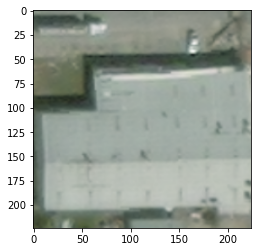

In [343]:
plt.imshow(X[44958])

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

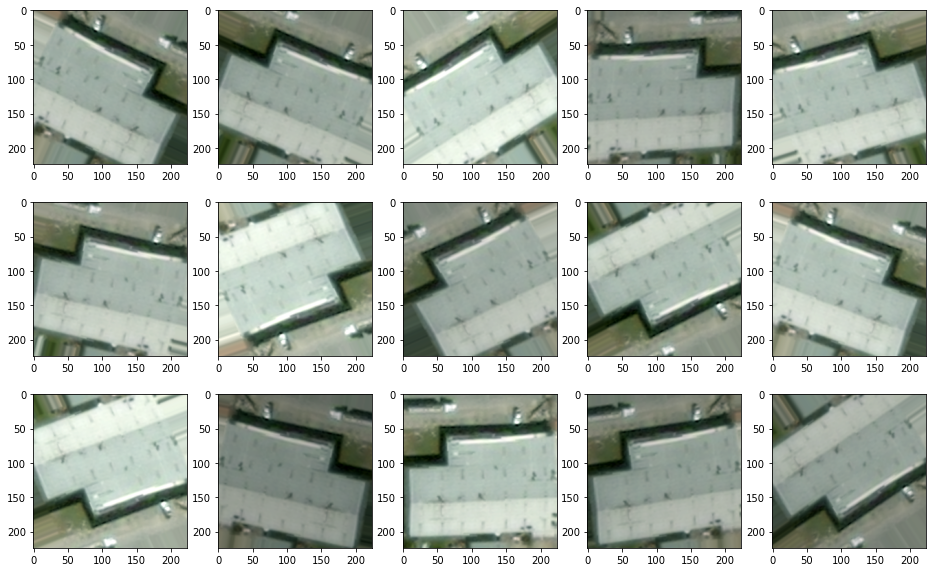

In [180]:
x_img = [next(sample_generator)[0][0].astype(int) for i in range(15)]
fig, ax = plt.subplots(3,5, figsize=(16, 10))
for i in range(15):
    ax[i%3][i%5].imshow(x_img[i])

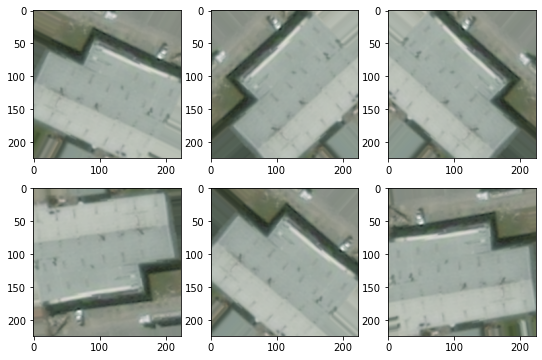

In [352]:
x_img = [next(sample_generator)[0][0].astype(int) for i in range(6)]
fig, ax = plt.subplots(2,3, figsize=(9, 6))
for i in range(6):
    ax[i%2][i%3].imshow(x_img[i])

Sample indices: [35862, 3171, 33409, 1385, 15402, 8666, 53720, 23692, 64232, 7730, 44958, 13207, 17264, 6321, 53797]


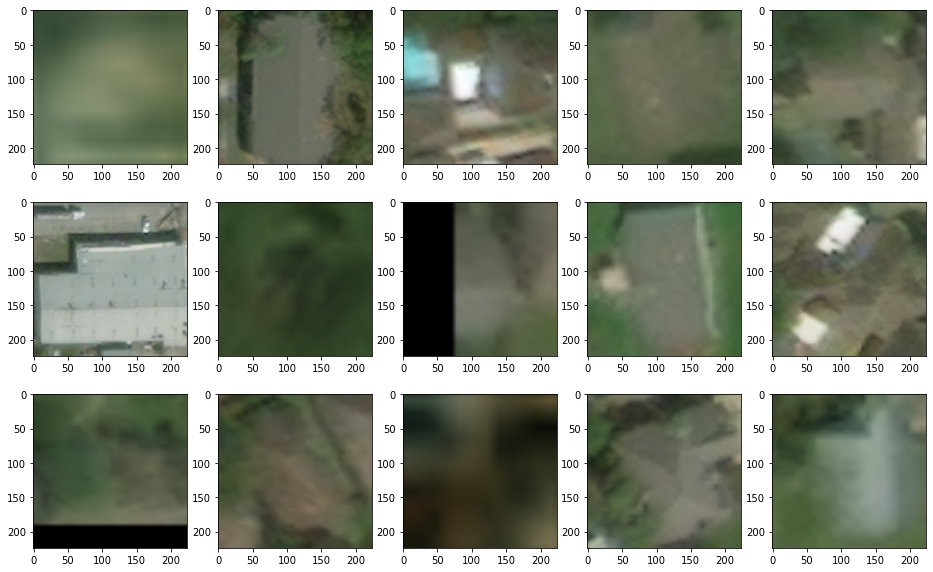

In [57]:
show_indices = train_indices[:15]
print('Sample indices:', show_indices)
x_img = X[show_indices]
fig, ax = plt.subplots(3,5, figsize=(16, 10))
for i in range(15):
    ax[i%3][i%5].imshow(x_img[i])

## Model Building

In [26]:
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Concatenate
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import losses, metrics, optimizers
from tensorflow.keras.applications import ResNet50V2
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')

In [27]:
def create_transfer_learning_resnet50():
    input_tensor = Input(shape=(224, 224, 3))
    base_model = ResNet50V2(include_top=False, 
                            weights='imagenet', 
                            input_tensor=input_tensor)
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    y = Dense(4, activation='softmax')(x)
    
    for layer in base_model.layers:
        layer.trainable = False
        
    c_model = Model(inputs=base_model.input, outputs=y)
    return c_model

In [27]:
def create_transfer_learning_retrain_resnet50():
    input_tensor = Input(shape=(224, 224, 3))
    base_model = ResNet50V2(include_top=False, 
                            weights='imagenet', 
                            input_tensor=input_tensor)
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    y = Dense(4, activation='softmax')(x)
    
    for layer in base_model.layers[:-4]:
        layer.trainable = False
        
    c_model = Model(inputs=base_model.input, outputs=y)
    return c_model

In [52]:
def create_transfer_learning_resnet50_new():
    input_tensor = Input(shape=(224, 224, 3))
    base_model = ResNet50V2(include_top=False, 
                            weights='imagenet', 
                            input_tensor=input_tensor)
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    y = Dense(4, activation='softmax')(x)
    
    for layer in base_model.layers:
        layer.trainable = False
        
    c_model = Model(inputs=base_model.input, outputs=y)
    return c_model

In [28]:
# Choose Optimizer
loss = losses.categorical_crossentropy
optimizer = optimizers.RMSprop(learning_rate=0.001)
metrics = ['AUC', 'categorical_accuracy', 'accuracy']

## Training on TPU

In [29]:
version = datetime.now().strftime("%Y%m%d-%H%M%S")

In [30]:
# Tensorboard Logging
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=os.environ['LOG_PATH'] + '/' + version, update_freq='batch')

In [31]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(os.environ['MODEL_PATH'] + '/' + version, save_best_only=True)

In [57]:
#tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
#strategy = tf.distribute.TPUStrategy(tpu_resolver)

In [58]:
with strategy.scope():
    model = create_transfer_learning_resnet50()
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [30]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [154]:
#%tensorboard --logdir logs/scalars

In [59]:
training_tpu_history = model.fit_generator(train_generator, steps_per_epoch=180, epochs=30,
                              validation_data=val_generator, validation_steps=21, 
                              verbose=1, callbacks=[tensorboard_callback, checkpoint_callback])  

Epoch 1/30
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


UnavailableError: 7 root error(s) found.
  (0) Unavailable: {{function_node __inference_train_function_773275}} failed to connect to all addresses
Additional GRPC error information from remote target /job:localhost/replica:0/task:0/device:CPU:0:
:{"created":"@1605518973.721898478","description":"Failed to pick subchannel","file":"third_party/grpc/src/core/ext/filters/client_channel/client_channel.cc","file_line":3948,"referenced_errors":[{"created":"@1605518973.721895995","description":"failed to connect to all addresses","file":"third_party/grpc/src/core/ext/filters/client_channel/lb_policy/pick_first/pick_first.cc","file_line":394,"grpc_status":14}]}
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
	 [[IteratorGetNextAsOptional]]
	 [[Pad_11/paddings/_154]]
  (1) Unavailable: {{function_node __inference_train_function_773275}} failed to connect to all addresses
Additional GRPC error information from remote target /job:localhost/replica:0/task:0/device:CPU:0:
:{"created":"@1605518973.721898478","description":"Failed to pick subchannel","file":"third_party/grpc/src/core/ext/filters/client_channel/client_channel.cc","file_line":3948,"referenced_errors":[{"created":"@1605518973.721895995","description":"failed to connect to all addresses","file":"third_party/grpc/src/core/ext/filters/client_channel/lb_policy/pick_first/pick_first.cc","file_line":394,"grpc_status":14}]}
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
	 [[IteratorGetNextAsOptional]]
	 [[Pad_7/paddings/_150]]
  (2) Unavailable: {{function_node __inference_train_function_773275}} failed to connect to all addresses
Additional GRPC error information from remote target /job:localhost/replica:0/task:0/device:CPU:0:
:{"created":"@1605518973.721898478","description":"Failed to pick subchannel","file":"third_party/grpc/src/core/ext/filters/client_channel/client_channel.cc","file_line":3948,"referenced_errors":[{"created":"@1605518973.721895995","description":"failed to connect to all addresses","file":"third_party/grpc/src/core/ext/filters/client_channel/lb_policy/pick_first/pick_first.cc","file_line":394,"grpc_status":14}]}
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
	 [[IteratorGetNextAsOptional]]
	 [[strided_slice_38/_210]]
  (3) Unavailable: {{function_node __inference_train_function_773275}} failed to connect to all addresses
Additional GRPC error information from remote target /job:localhost/replica:0/task:0/device:CPU:0:
:{"created":"@1605518973.721898478","description":"Failed to pick subchannel","file":"third_party/grpc/src/core/ext/filters/client_channel/client_channel.cc","file_line":3948,"referenced_errors":[{"created":"@1605518973.721895995","description":"failed to connect to all addresses","file":"third_party/grpc/src/core/ext/filters/client_channel/lb_policy/pick_first/pick_first.cc","file_line":394,"grpc_status":14}]}
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
	 [[IteratorGetNextAsOptional]]
	 [[strided_slice_120/_294]]
  (4) Unavailable: {{function_node __inference_train_functi ... [truncated]

In [33]:
import warnings
warnings.filterwarnings('ignore')

In [55]:
X[:3200].nbytes / 1e9

1.9267584

In [32]:
histories = []

In [ ]:
training_history = model.fit(X[train_indices[0:3200]], Y[train_indices[0:3200]],
                             class_weight=class_weights, 
                             batch_size=160, 
                             epochs=20, 
                             validation_data=(X[test_indices[:2800]], Y[test_indices[:2800]]),
                             callbacks=[tensorboard_callback]) #, checkpoint_callback])

In [61]:
histories.append(training_history.history)

## CPU Training

In [32]:
model = create_transfer_learning_resnet50()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [33]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

### Supplying Data Directly

In [38]:
training_history = model.fit(X[train_indices], Y[train_indices],
                             class_weight=class_weights, 
                             batch_size=640, 
                             epochs=30, 
                             validation_data=(X[test_indices], Y[test_indices]),
                             callbacks=[tensorboard_callback, checkpoint_callback])

Epoch 1/30
 1/90 [..............................] - ETA: 0s - loss: 2.0791 - auc: 0.6511 - categorical_accuracy: 0.3750 - accuracy: 0.3750WARNING:tensorflow:From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
90/90 [==============================] - ETA: 0s - loss: 1.2439 - auc: 0.6867 - categorical_accuracy: 0.4123 - accuracy: 0.4123 WARNING:tensorflow:From /opt/conda/lib/python3.7/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied

KeyboardInterrupt: 

In [ ]:
np.savez_compressed('train_2_history_30_epochs.npz', history=training_history.history)

In [38]:
training_history.history

{'loss': [1.2194987535476685,
  1.121427059173584,
  1.0869778394699097,
  1.0622739791870117,
  1.042465090751648,
  1.0237817764282227,
  1.008297324180603,
  0.9953495264053345,
  0.9834609031677246,
  0.965658962726593,
  0.9595416784286499,
  0.9469614624977112,
  0.9384633302688599,
  0.9291099905967712,
  0.9173338413238525,
  0.9094817042350769,
  0.8968583941459656,
  0.8944358825683594,
  0.8829676508903503,
  0.8706070780754089],
 'auc': [0.6940663456916809,
  0.7436422109603882,
  0.7605880498886108,
  0.7709057331085205,
  0.779240071773529,
  0.7854470014572144,
  0.7917046546936035,
  0.7972068190574646,
  0.7999603748321533,
  0.8067571520805359,
  0.8081527948379517,
  0.8125087022781372,
  0.814653217792511,
  0.8178064823150635,
  0.8205482363700867,
  0.8229261636734009,
  0.8276404738426208,
  0.827650785446167,
  0.831851601600647,
  0.8342704176902771],
 'categorical_accuracy': [0.40725693106651306,
  0.46265625953674316,
  0.48006945848464966,
  0.49687498807907

### Supplying Data Generator

In [34]:
training_aug_shear_history = model.fit_generator(train_generator, steps_per_epoch=180, epochs=30,
                              validation_data=val_generator, validation_steps=21, 
                              verbose=1, callbacks=[tensorboard_callback, checkpoint_callback])     

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
  1/180 [..............................] - ETA: 0s - loss: 1.6645 - auc: 0.5060 - categorical_accuracy: 0.2250 - accuracy: 0.2250WARNING:tensorflow:From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
180/180 [==============================] - ETA: 0s - loss: 1.0978 - auc: 0.7802 - categorical_accuracy: 0.5264 - accuracy: 0.5264WARNING:tensorflow:From /opt/conda/lib/python3.7/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updat

In [35]:
np.savez_compressed('train_aug_shear_history_30_epochs.npz', history=training_aug_shear_history.history)

In [36]:
np.savez_compressed('train_aug_shear_indices.npz', train=train_indices, test=test_indices)

In [37]:
training_aug_shear_history.history

{'loss': [1.097822904586792,
  1.0149023532867432,
  0.9955019950866699,
  0.9796343445777893,
  0.9688385128974915,
  0.9600730538368225,
  0.9553563594818115,
  0.9501575231552124,
  0.9447670578956604,
  0.9407118558883667,
  0.9385788440704346,
  0.9324528574943542,
  0.9291648268699646,
  0.9249460101127625,
  0.9242591261863708,
  0.9229401350021362,
  0.9206887483596802,
  0.9180434346199036,
  0.9179263114929199,
  0.9154442548751831,
  0.9111363291740417,
  0.9111384153366089,
  0.9100143909454346,
  0.9107426404953003,
  0.9067361950874329,
  0.9056973457336426,
  0.9067930579185486,
  0.9016276001930237,
  0.9025821089744568,
  0.9013046026229858],
 'auc': [0.7802159786224365,
  0.8150457739830017,
  0.8227143883705139,
  0.8289713263511658,
  0.8328524827957153,
  0.8363596200942993,
  0.8381057381629944,
  0.8398938179016113,
  0.8416356444358826,
  0.8430608510971069,
  0.8441430926322937,
  0.8458773493766785,
  0.8469038009643555,
  0.848568320274353,
  0.84885346889495

### Load Model

In [28]:
model_2 = tf.keras.models.load_model(os.environ['MODEL_PATH'] + '/' + '20201115-204641')

In [29]:
for layer in model_2.layers[:-6]:
    layer.trainable = False

In [30]:
model_2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

## Evaluation

In [394]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, f1_score

In [103]:
from sklearn.utils.class_weight import compute_sample_weight

In [149]:
from sklearn.metrics import classification_report

In [131]:
from tensorflow.math import confusion_matrix as tf_confusion_matrix
import seaborn as sns
import pandas as pd

In [195]:
from sklearn.metrics import roc_curve, auc

In [39]:
predictions = model.predict(resnet_preprocess(X[test_indices]))

In [371]:
predictions_holdout = model.predict(resnet_preprocess(X_holdout))

In [385]:
predictions_training = model.predict(resnet_preprocess(X[train_indices]))

In [372]:
predictions_holdout[:10]

array([[7.10184932e-01, 3.05706039e-02, 2.58686334e-01, 5.58073865e-04],
       [5.95547318e-01, 1.65230021e-01, 1.90280750e-01, 4.89418618e-02],
       [4.49530512e-01, 2.81797439e-01, 2.12389186e-01, 5.62828369e-02],
       [7.71769643e-01, 4.53277826e-02, 1.82388023e-01, 5.14581450e-04],
       [8.53777826e-01, 8.21338519e-02, 6.38456792e-02, 2.42622104e-04],
       [6.83770001e-01, 7.99577385e-02, 1.73709050e-01, 6.25631660e-02],
       [7.65482068e-01, 1.76979378e-01, 5.44761308e-02, 3.06246104e-03],
       [5.64246595e-01, 2.17126548e-01, 2.02484518e-01, 1.61423106e-02],
       [4.44274217e-01, 9.21750963e-02, 4.61224496e-01, 2.32619303e-03],
       [7.49084234e-01, 6.99883923e-02, 1.15356416e-01, 6.55708835e-02]],
      dtype=float32)

### Sample Predictions

In [47]:
predictions[:10]

array([[6.19632959e-01, 1.85297638e-01, 1.85952574e-01, 9.11689550e-03],
       [6.15170419e-01, 3.72533411e-01, 1.20923202e-02, 2.03841890e-04],
       [4.16354299e-01, 3.37494880e-01, 1.57432482e-01, 8.87183249e-02],
       [6.65271878e-01, 3.09595466e-02, 2.93311834e-01, 1.04567120e-02],
       [8.28522444e-01, 1.63086787e-01, 8.11155606e-03, 2.79220723e-04],
       [8.53472233e-01, 6.71817362e-02, 7.90977031e-02, 2.48250348e-04],
       [5.91018438e-01, 1.06652394e-01, 2.93413579e-01, 8.91562179e-03],
       [7.94059157e-01, 8.98199528e-02, 1.15852378e-01, 2.68467935e-04],
       [7.45240211e-01, 5.64111508e-02, 1.83498055e-01, 1.48505010e-02],
       [5.22367299e-01, 1.12859771e-01, 2.69057393e-01, 9.57154855e-02]],
      dtype=float32)

In [67]:
hard_max_predictions = np.argmax(predictions, axis=1)
hard_max_predictions[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0,
       2, 0, 2, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 1, 2, 0, 1,
       0, 0, 1, 0, 2, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 2, 0, 0,
       2, 3, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0])

No damage prediction example:


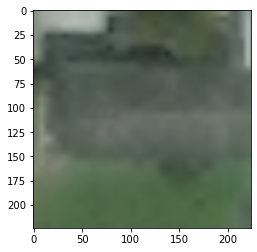

In [49]:
print("No damage prediction example:")
plt.imshow(X[test_indices[1]])

Minor damage prediction example:


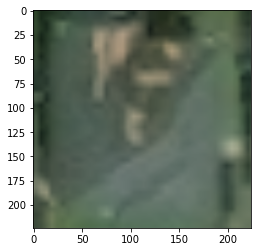

In [333]:
print("Minor damage prediction example:")
plt.imshow(X[test_indices[195]])

Major damage prediction example:


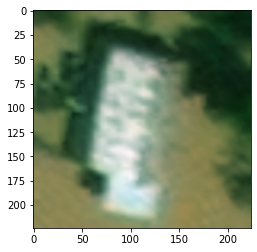

In [340]:
print("Major damage prediction example:")
plt.imshow(X[test_indices[94]]) #94

Destroyed damage prediction example:


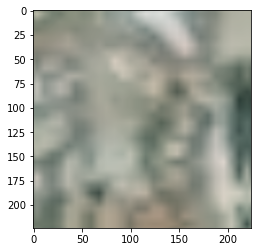

In [66]:
print("Destroyed damage prediction example:")
plt.imshow(X[test_indices[89]])

### Calculate Metrics Training Set

In [386]:
hard_max_predictions_training = np.argmax(predictions_training, axis=1)
hard_max_predictions_training[:100]

array([2, 1, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 3, 0, 0, 0, 1, 2, 0, 1, 0, 0,
       0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 3, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 2, 1, 0, 0, 0, 2, 1, 0, 0, 0])

In [387]:
true_labels_training = np.argmax(Y[train_indices], axis=1)
true_labels_training[:100]

array([2, 3, 2, 0, 2, 0, 1, 1, 2, 0, 1, 0, 3, 0, 0, 0, 1, 2, 0, 1, 0, 0,
       0, 0, 3, 2, 0, 1, 2, 1, 1, 0, 1, 3, 1, 0, 0, 3, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 1, 2, 0, 0, 0, 0, 2,
       2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 2, 2, 0, 1, 0, 0, 2, 1, 0, 0, 1])

In [388]:
print('Training Data Building Image #: {}'.format(hard_max_predictions_training.shape[0]))

Training Data Building Image #: 57600


In [389]:
print('Accuracy score on training data:')
accuracy_score(true_labels_training, hard_max_predictions_training)

Accuracy score on training data:


0.6389930555555555

In [390]:
print('Balanced accuracy score on training data:')
balanced_accuracy_score(true_labels_training, hard_max_predictions_training)

Balanced accuracy score on training data:


0.49701365383038837

In [391]:
print('ROC-AUC score on training data:')
roc_auc_score(Y[train_indices], predictions_training, multi_class='ovo', average='micro')

ROC-AUC score on training data:


0.8719825053650656

In [400]:
print('F1 score on training data:')
f1_score(true_labels_training, hard_max_predictions_training, average='micro')

F1 score on training data:


0.6389930555555555

### Calculate Metrics Validation Set

In [381]:
print('Validation Data Building Image #: {}'.format(hard_max_predictions.shape[0]))

Validation Data Building Image #: 8400


In [335]:
hard_max_predictions[200:300]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 2, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 2, 0, 0,
       0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1])

In [336]:
true_labels = np.argmax(Y[test_indices], axis=1)
true_labels[200:300]

array([2, 0, 0, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 2, 0, 2, 1,
       0, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 3, 0, 0, 0, 1, 1, 0, 0, 2, 0, 1,
       1, 0, 3, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 1, 1, 0, 3, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 1, 1, 2, 0, 0, 2, 0, 2, 0, 0,
       0, 1, 2, 0, 0, 2, 0, 0, 1, 1, 2, 3])

In [104]:
sample_weights = compute_sample_weight(class_weights, true_labels)

In [94]:
print('Accuracy score on validation data:')
accuracy_score(true_labels, hard_max_predictions)

Accuracy score on validation data:


0.6260714285714286

In [108]:
print('Balanced accuracy score on validation data:')
balanced_accuracy_score(true_labels, hard_max_predictions, sample_weight=sample_weights)

Balanced accuracy score on validation data:


0.4841253653899957

In [98]:
print('ROC-AUC score on validation data:')
roc_auc_score(Y[test_indices], predictions, multi_class='ovo', average='micro')

ROC-AUC score on validation data:


0.8608575562169313

In [119]:
print('F1 score on validation data:')
f1_score(true_labels, hard_max_predictions, average='micro')

F1 score on validation data:


0.6260714285714286

### Calculate Metrics Holdout Set

In [382]:
print('Holdout Data Building Image #: {}'.format(hard_max_predictions_holdout.shape[0]))

Holdout Data Building Image #: 19829


In [373]:
hard_max_predictions_holdout = np.argmax(predictions_holdout, axis=1)
hard_max_predictions_holdout[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [374]:
true_labels_holdout = np.argmax(Y_holdout, axis=1)
true_labels_holdout[:100]

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0,
       0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 0])

In [375]:
print('Accuracy score on holdout data:')
accuracy_score(true_labels_holdout, hard_max_predictions_holdout)

Accuracy score on holdout data:


0.6508648948509759

In [377]:
print('Balanced accuracy score on holdout data:')
balanced_accuracy_score(true_labels_holdout, hard_max_predictions_holdout)

Balanced accuracy score on holdout data:


0.5026846075507839

In [383]:
print('ROC-AUC score on holdout data:')
roc_auc_score(Y_holdout, predictions_holdout, multi_class='ovo', average='micro')

ROC-AUC score on validation data:


0.8698152852898977

In [384]:
print('F1 score on holdout data:')
f1_score(true_labels_holdout, hard_max_predictions_holdout, average='micro')

F1 score on holdout data:


0.6508648948509759

### Metric Reporting & Visualization

In [113]:
target_names = ['No Damage', 'Minor Damage', 'Major Damage', 'Destroyed']

#### Classification Report

In [114]:
print(classification_report(true_labels, hard_max_predictions, target_names=target_names))

              precision    recall  f1-score   support

   No Damage       0.65      0.89      0.75      4398
Minor Damage       0.53      0.44      0.48      1844
Major Damage       0.60      0.22      0.33      1752
   Destroyed       0.58      0.39      0.46       406

    accuracy                           0.63      8400
   macro avg       0.59      0.48      0.51      8400
weighted avg       0.61      0.63      0.59      8400



In [121]:
preprocessed_x_test = resnet_preprocess(X[test_indices])

#### Confusion Matrices

In [326]:
def plot_confusion_matrix(y_true, y_pred, class_names, normalize=False):
    con_mat = tf_confusion_matrix(y_true, y_pred).numpy()
    
    if normalize:
        con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=0)[np.newaxis, :], decimals=2)
    else:
        con_mat_norm = np.around(con_mat.astype('int'), decimals=2)
        
    con_mat_df = pd.DataFrame(con_mat_norm, index=class_names, columns=class_names)
    
    figure = plt.figure(figsize=(6, 6))
    
    if normalize:
        sns.heatmap(con_mat_df, annot=True, fmt='g', cmap=plt.cm.Blues, cbar=False)
    else:
        sns.heatmap(con_mat_df, annot=True, fmt='g', cmap=plt.cm.Blues, vmin=0, vmax=1250, cbar=False)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if normalize:
        plt.title('Convolutional Neural Network Normalized Confusion Matrix')
    else:
        plt.title('Convolutional Neural Network Confusion Matrix')
    return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

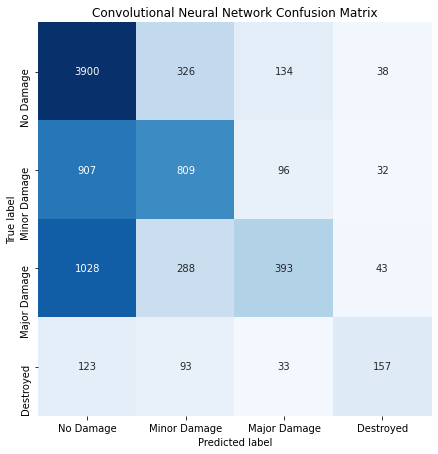

In [327]:
plot_confusion_matrix(true_labels, hard_max_predictions, target_names, normalize=False)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

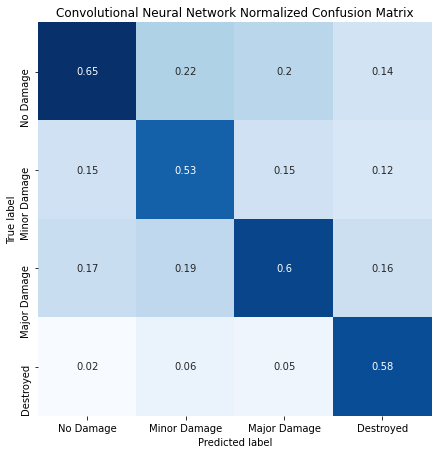

In [328]:
plot_confusion_matrix(true_labels, hard_max_predictions, target_names, normalize=True)

In [165]:
print('Label proportions in validation set:')
for i in range(4):
    print('\t{}: \t{}'.format(target_names[i], np.sum(Y[test_indices], axis=0)[i]))

Label proportions in validation set:
	No Damage: 	4398.0
	Minor Damage: 	1844.0
	Major Damage: 	1752.0
	Destroyed: 	406.0


#### Multi-Class ROC-AUC Curves

In [173]:
n_classes = predictions.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y[test_indices][:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

roc_auc

{0: 0.7930088218737379,
 1: 0.7680857163843887,
 2: 0.7757082845666498,
 3: 0.9078326602094429}

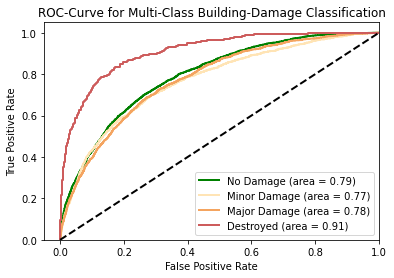

In [194]:
colors = ['green', 'moccasin', 'sandybrown', 'indianred']
plt.figure(figsize=(6, 4))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], lw=2, color=color, label='{0} (area = {1:0.2f})'.format(target_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Curve for Multi-Class Building-Damage Classification')
plt.legend(loc="lower right")
plt.show()

#### Plot Model Learning Curves

In [219]:
!ls

20201114-112009-small_resnet50_2400_samples.tf
ctpu
data
diagnose_tensorboard.py
full_data.npz
full_data_VGG_processed.npz
Model Training Evaluation.ipynb
Model Training.ipynb
raw_hurricane-florence.npz
raw_hurricane-harvey.npz
raw_hurricane-matthew.npz
raw_hurricane-michael.npz
train_aug_history_30_epochs.npz
train_aug_indices.npz
train_aug_retrain_history_30_epochs.npz
train_aug_retrain_indices.npz
train_aug_shear_history_30_epochs.npz
train_aug_shear_indices.npz
train_history_20_epochs.npz
training.py
training.py~
Y_data.npz


In [235]:
aug_history_30 = np.load('train_aug_history_30_epochs.npz', allow_pickle=True)['history'].tolist()
aug_retrain_history_30 = np.load('train_aug_retrain_history_30_epochs.npz', allow_pickle=True)['history'].tolist()
aug_shear_history_30 = np.load('train_aug_shear_history_30_epochs.npz', allow_pickle=True)['history'].tolist()
history_20 = np.load('train_history_20_epochs.npz', allow_pickle=True)['arr_0'].tolist()

In [295]:
def plot_learning_curve(history, title):
    train_loss = history['loss']
    val_loss = history['val_loss']
    steps = list(range(1, len(train_loss) + 1))
    
    min_val_loss = np.round(np.min(val_loss), 3)
    
    plt.figure(figsize=(8, 3))
    plt.plot(steps, train_loss, '-r', label='Training Loss')
    plt.plot(steps, val_loss, '-b', label='Validation Loss')
    plt.hlines(min_val_loss, 1, 30, colors='k', linestyles='dotted', label='Min Validation Loss: {}'.format(min_val_loss))

    plt.xlabel('Epochs (1 Epoch = 57.6k buildings)')
    plt.ylabel('Loss')
    plt.ylim((0.80, 1.15))
    plt.title(title)
    plt.legend(loc='upper right')
    plt.title(title)

    return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

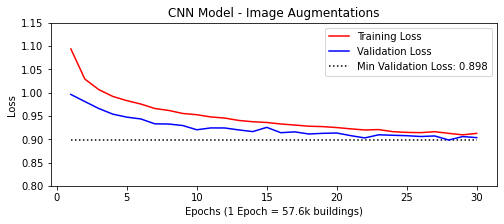

In [296]:
plot_learning_curve(aug_history_30, 'CNN Model - Image Augmentations')

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

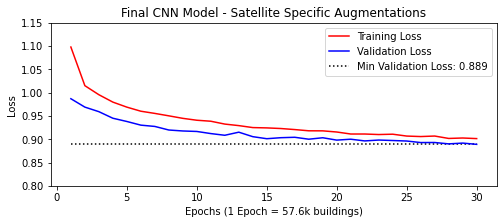

In [297]:
plot_learning_curve(aug_shear_history_30, 'Final CNN Model - Satellite Specific Augmentations')

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

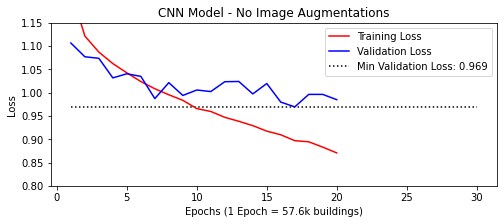

In [298]:
plot_learning_curve(history_20, 'CNN Model - No Image Augmentations')

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

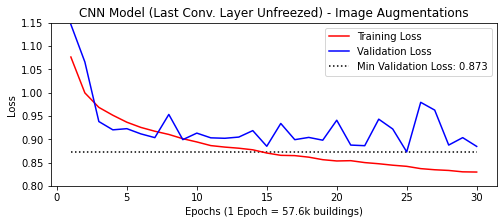

In [299]:
plot_learning_curve(aug_retrain_history_30, 'CNN Model (Last Conv. Layer Unfreezed) - Image Augmentations')

# Visualize What Our Model Learns

### Helper Functions

In [427]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [409]:
img_width = 224
img_height = 224

In [613]:
layer_name = 'conv3_block4_out' #'conv2_block2_out' #'conv2_block3_3_conv' #

In [614]:
# Set up a model that returns the activation values for our target layer
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

In [615]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

In [616]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img


In [617]:
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

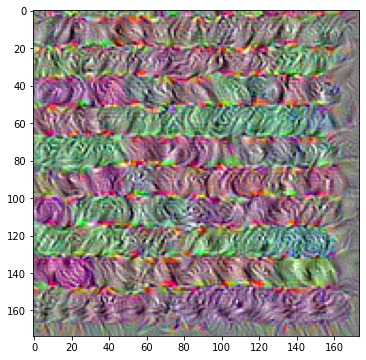

In [618]:
from IPython.display import Image, display

figure = plt.figure(figsize=(6, 6))
loss, img = visualize_filter(0)
plt.imshow(img)

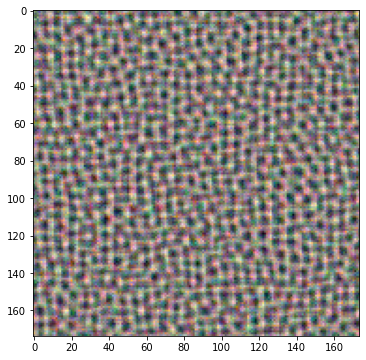

In [578]:
figure = plt.figure(figsize=(6, 6))
loss, img = visualize_filter(0)
plt.imshow(img)

### Get Mean Activations For Layers

In [619]:
no_damage_indices = [i for i in range(len(true_labels)) if true_labels[i] == 0][:1000]
destroyed_indices = [i for i in range(len(true_labels)) if true_labels[i] == 3][:1000]

In [620]:
no_damage_test = [test_indices[i] for i in no_damage_indices]
destroyed_test = [test_indices[i] for i in destroyed_indices]

In [621]:
no_damage_inputs = X[no_damage_test]
destroyed_inputs = X[destroyed_test]

In [622]:
no_damage_test[:10]

[53368, 1419, 56022, 57413, 5218, 5868, 54766, 17151, 23696, 45955]

In [623]:
destroyed_test[:10]

[60365, 10225, 45590, 35338, 48246, 30987, 33115, 14194, 40879, 32634]

In [624]:
no_damage_activations = feature_extractor.predict(no_damage_inputs)

In [625]:
destroyed_activations = feature_extractor.predict(destroyed_inputs)

In [626]:
no_damage_activations.shape

(1000, 14, 14, 512)

In [627]:
destroyed_activations.shape

(406, 14, 14, 512)

In [605]:
diff_activations = []
for i in range(destroyed_activations.shape[-1]):
    diff_activations.append(np.mean(no_damage_activations[:,:,:,i]) - np.mean(destroyed_activations[:,:,:,i]))
diff_activations = np.array(diff_activations)

In [628]:
mean_activations_no_damage = np.mean(no_damage_activations.reshape((1000*14*14, 512)), axis=0)

In [629]:
mean_activations_destroyed = np.mean(destroyed_activations.reshape((406*14*14, 512)), axis=0)

In [630]:
mean_activations_no_damage.shape

(512,)

In [631]:
diff_activations = mean_activations_no_damage - mean_activations_destroyed

In [632]:
highest_activations_no_damage = diff_activations.argsort()[-4:]
highest_activations_no_damage

array([374, 410, 246,  38])

In [633]:
highest_activations_destroyed = diff_activations.argsort()[:4]
highest_activations_destroyed

array([455,  85, 451, 349])

### No Damage

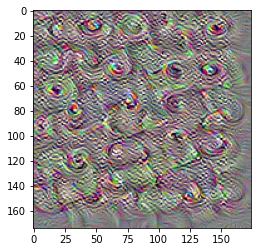

In [634]:
 _, img = visualize_filter(highest_activations_no_damage[0])
plt.imshow(img)

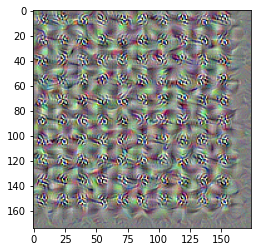

In [635]:
 _, img = visualize_filter(highest_activations_no_damage[1])
plt.imshow(img)

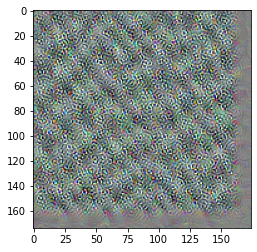

In [636]:
 _, img = visualize_filter(highest_activations_no_damage[2])
plt.imshow(img)

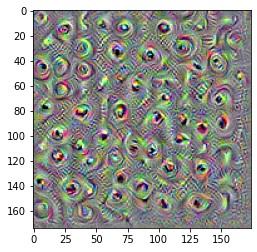

In [637]:
 _, img = visualize_filter(highest_activations_no_damage[3])
plt.imshow(img)

### Destroyed

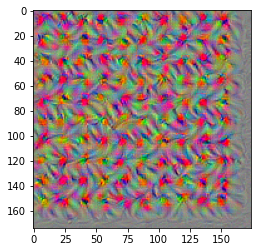

In [638]:
 _, img = visualize_filter(highest_activations_destroyed[3])
plt.imshow(img)

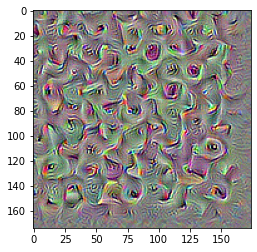

In [639]:
 _, img = visualize_filter(highest_activations_destroyed[2])
plt.imshow(img)

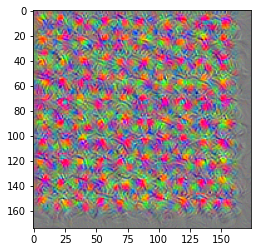

In [640]:
 _, img = visualize_filter(highest_activations_destroyed[1])
plt.imshow(img)

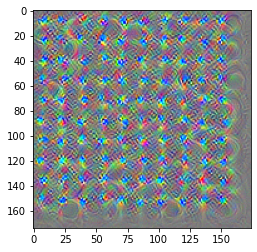

In [641]:
 _, img = visualize_filter(highest_activations_destroyed[0])
plt.imshow(img)